In [85]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils.load import add_noise, load_data
from utils.params import set_param

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.dataset import SlowEarthquakeDataset

sns.set_theme(style="ticks")
np.random.seed(42)

# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [87]:
EXPERIMENT = "b726"
TS_COLUMN = "det_shear_stress"

dataset = SlowEarthquakeDataset([EXPERIMENT])
ds_exp = dataset[EXPERIMENT]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

ts_data = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

ts_data = ts_data.dropna(axis=1)
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,0.112433,9.515997,15.003165,21.927258,18.706851,0.00
1,0.116169,9.519734,15.006345,21.927536,18.707201,0.01
2,0.114211,9.517776,14.988926,21.927373,18.706995,0.02
3,0.120005,9.523571,15.009077,21.927632,18.707321,0.03
4,0.118803,9.522370,14.996757,21.927744,18.707461,0.04


In [88]:
# Downsampling (conolutional) - have less data points to be able to train
ts_data = ts_data.rolling(window=int(1e2), step=int(1e2)).mean().dropna()
ts_data = ts_data.reset_index(drop=True)
ts_data = ts_data.dropna()
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,0.134489,9.538104,15.000499,21.932221,18.713092,0.505
1,-0.021863,9.381855,14.999111,21.943560,18.727355,1.505
2,-0.077303,9.326519,15.000578,21.954033,18.740541,2.505
3,0.024961,9.428886,15.000597,21.963154,18.752032,3.505
4,0.106275,9.510303,15.000834,21.972459,18.763757,4.505


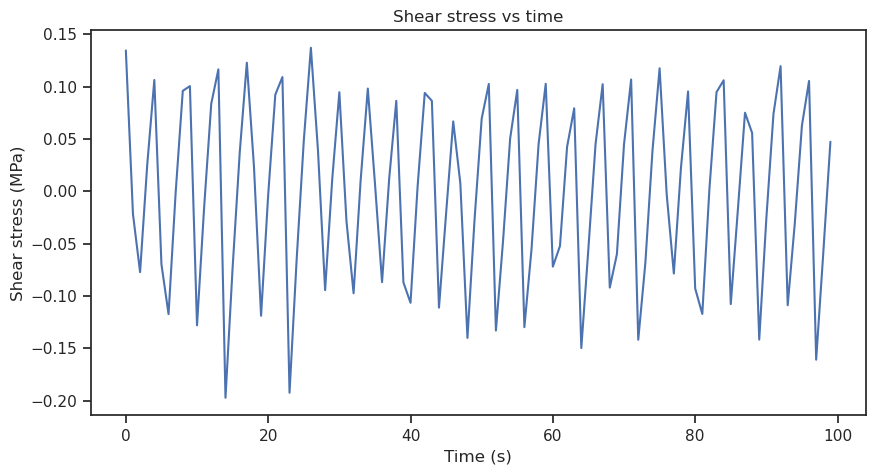

In [89]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the first 1000 data points
ax.plot(ts_data[TS_COLUMN][:100])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Shear stress (MPa)")
ax.set_title("Shear stress vs time")
plt.show()

start_idx [15795   860  5390 11964 11284  6265 16850  4426 14423 11363 16023  8322
  1685   769  2433  5311  5051  6420 17568 19769  6396  8666 18942 18431
  2747   189 19118  3005  1899  1267 17912 11394  3556  3890  8838 14502
 10627  8792 10555 10253  8433 10233 11016  2612 15787 17159 12206  8226
 14541  3152  1585  3943 19457  1021 11653 10805 13417  7989  9692 12990
  6873  5675   161  4297   995 11534  7629  1016  8529 17262  9268 12185
  6331  8571  7208  5276 18446 16448 16216  8006  2568  2027  2695 15422
  5258  6736   391 13986 12666  5892  3561  6184 19483  8392 13067 15265
 19488  2454 11837 14039 19115 10965  9762  5056 14948  8110 13773 17412
   502  6910 12685   206 17868 15934 17247 19174  8755 12383 18141 14820
  7574  6374  1678 19626  1059 16198  9914 19541 10817 10921  9789 16312
 11252  2693 13931  3627 16157 10173 18047 10230 15707 11494  1306  6776
  9474  7526  5530  3748 13545   663  1998  7994 17879  3304 18237 13808
  6585 17675 19965 11649  1636 17082  473

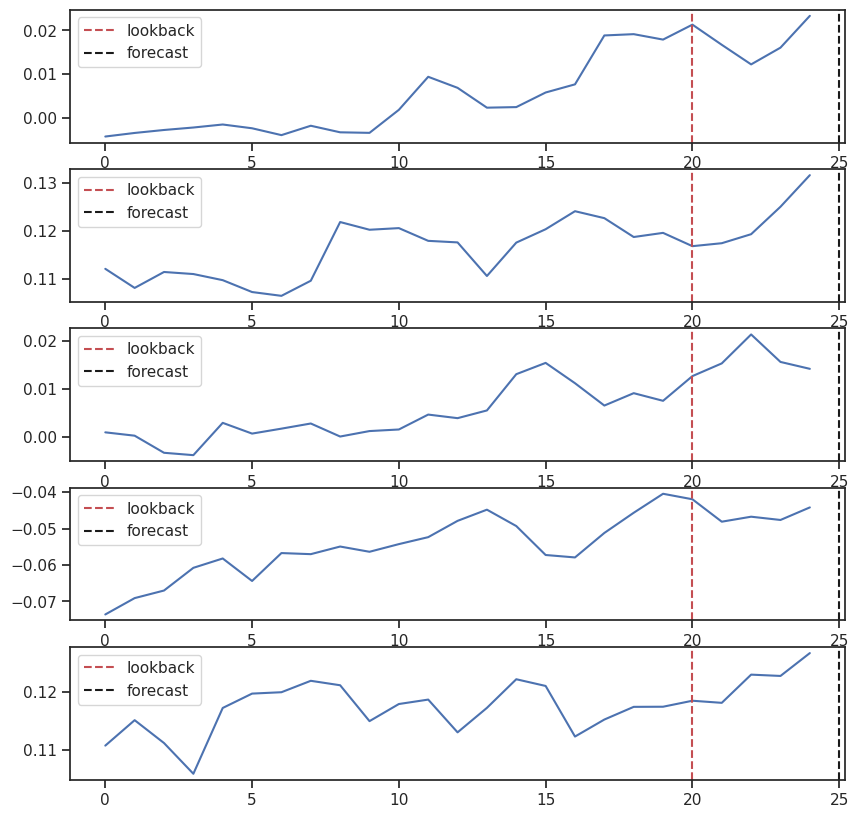

In [90]:
# Randomly select sample 2000 steps, make 1500 the input and 500 the forecast (i.e. 3:2 ratio)
lookback = 20
forecast = 5

# number of samples 
samples = 320

# Create a array of 1000 random start indices
start_idx = np.random.randint(0, len(X) - lookback - forecast, size=samples)
print("start_idx", start_idx)

# Input: samples of length lookback
# Output: samples of length forecast
# Model: LSTM that takes lookback samples and outputs forecast samples

# Create subplots of 5 first samples with labebeld lookback and forecast points
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for i, idx in enumerate(start_idx[:5]):
    axs[i].plot(X[idx : idx + lookback + forecast])
    axs[i].axvline(lookback, c="r", ls="--", label="lookback")
    axs[i].axvline(lookback + forecast, c="k", ls="--", label="forecast")
    axs[i].legend()

In [91]:
# create X_train, y_train and X_test, y_test datasets
def create_dataset(X, start_idx, lookback, forecast, train_test_split=0.8):
    """
    Create X_train, y_train and X_test, y_test datasets from X
    X_train is a collection of samples of length lookback
    y_train is a collection of samples of length forecast
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Split into train and test sets
    train_size = int(len(start_idx) * train_test_split)
    train_idx = start_idx[:train_size]
    test_idx = start_idx[train_size:]

    # Create X_train and y_train
    for idx in train_idx:
        X_train.append(X[idx : idx + lookback])
        y_train.append(X[idx + lookback : idx + lookback + forecast])

    # Create X_test and y_test
    for idx in test_idx:
        X_test.append(X[idx : idx + lookback])
        y_test.append(X[idx + lookback : idx + lookback + forecast])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = create_dataset(X, start_idx, lookback, forecast)

# # Plot the first 5 samples of X_train and y_train
# fig, axs = plt.subplots(5, 1, figsize=(10, 10))
# for i in range(5):
#     axs[i].plot(X_train[i], label="X_train")
#     axs[i].plot(np.arange(lookback, lookback + forecast), y_train[i], label="y_train")
#     axs[i].legend()

print(len(y_train[0]))
print(len(X_train[0]))
    

5
20


In [94]:
# LSTM model to carry out multi-step forecasting along forecast
# input: [batch size, lookback, 1]
# output: [batch size, forecast, 1]

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=forecast):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialise hidden state and cell state
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # Only take the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

In [95]:
# Train the model
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 32

for i in range(epochs):
    for j in range(0, len(X_train), batch_size):
        X_batch = X_train[j : j + batch_size]
        y_batch = y_train[j : j + batch_size]

        # Reshape data to (batch_size, lookback, input_size)
        X_batch = torch.Tensor(X_batch.reshape(batch_size, lookback, 1)).to(device)
        y_batch = torch.Tensor(y_batch.reshape(batch_size, forecast, 1)).to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Calculate loss
        loss = loss_function(y_pred, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"epoch: {i:3} loss: {loss.item():10.8f}")

/home/users/ashine/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 5, 1])) that is different to the input size (torch.Size([32, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (32) must match the size of tensor b (5) at non-singleton dimension 1

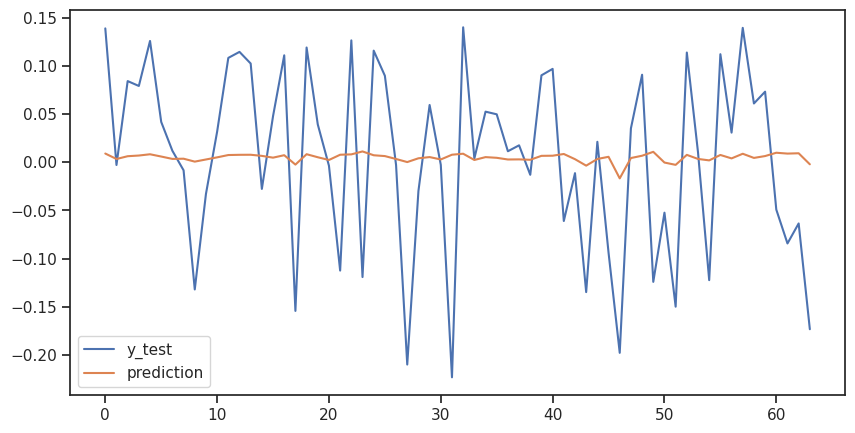

In [ ]:
# Do a forward pass on the test set and plot the predictions
with torch.no_grad():
    preds = []
    for i in range(0, len(X_test), batch_size):
        X_batch = X_test[i : i + batch_size]
        X_batch = torch.Tensor(X_batch.reshape(batch_size, lookback, 1)).to(device)
        preds.append(model(X_batch).cpu().numpy())

preds = np.array(preds).flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test.flatten(), label="y_test")
ax.plot(preds, label="prediction")
ax.legend()

In [ ]:
# TODO: Do min/max scalling